# Blue Crow Analytics Exercise
Write a method that assigns players on each team to a tactical unit (ie defensive line, midfield line, etc).
1.     Describe your general approach and any difficulties you encountered
2.     Where does your approach work well and where does it break down?
3.     How do you think it could be improved given more resources?
4.     What are some applications of this model?

In [1]:
import json
import pandas as pd
import numpy as np
from mplsoccer import Pitch

## Read the match_data file
1. Get the pitch dimensions
2. Identify the IDs of the referees and the ball, to be filtered out of the strcutured_data
3. Keep the players information in a data frame

In [2]:
#available match IDs:
#match_id = 4039
#match_id = 3749
match_id = 3518
#match_id = 3442
#match_id = 2841
#match_id = 2440
#match_id = 2417
#match_id = 2269
#match_id = 2068


match_fname = '../data/matches/{}/match_data.json'.format(match_id)
with open(match_fname, 'r') as f:
    match_data = json.loads(f.read())

pitch_length = match_data['pitch_length']
pitch_width = match_data['pitch_width']
referee_object_ids = [ ref['trackable_object'] for ref in match_data['referees'] ]
objects_to_filter = [ ref['trackable_object'] for ref in match_data['referees'] ]
ball_object_id = match_data['ball']['trackable_object']

objects_to_filter.append(ball_object_id)

print('Pitch length, width: {},{}'.format(pitch_length, pitch_width))
print('Ball object id:{}'.format(ball_object_id))
print('Referee object ids: {}'.format(referee_object_ids))
print('Object ids to filter: {}'.format(objects_to_filter))

Pitch length, width: 105,68
Ball object id:55
Referee object ids: [11922]
Object ids to filter: [11922, 55]


In [3]:
match_players = pd.json_normalize(match_data['players'])

## Read the structured_data file
1. Keep a subset of the json fields
2. Drop the frames with no info
3. Filter out the referees and ball info
4. **Flip the sign of the x coordinates from the second half of the game:** needed for accurate counting of each player's position in each tactical zone (done later)
5. Join the players info from match_data with their postional info from strutured_data

In [4]:
struct_fname = '../data/matches/{}/structured_data.json'.format(match_id)
with open(struct_fname, 'r') as f:
    struct_data = json.loads(f.read())

In [5]:
struct_df = pd.json_normalize(struct_data,'data', ['period', 'frame', 'time', ['possession', 'trackable_object'], ['possession', 'group']])
struct_df.dropna(subset=['period', 'trackable_object'], inplace=True)
struct_df['trackable_object'] = struct_df['trackable_object'].astype(int)
for id_to_drop in objects_to_filter:
    struct_df = struct_df[ struct_df['trackable_object'] != id_to_drop]

In [6]:
# Fold second half coordinates onto first half
mult = [1 if period == 1 else -1 for period in struct_df['period']]
struct_df['x'] = struct_df['x'] * mult
struct_df.head()

,y,x,group_name,track_id,trackable_object,z,period,frame,time,possession.trackable_object,possession.group
49,2.474447,12.460180,NaN,15,8052,NaN,1,577,0:00.00,None,None
50,-5.810590,8.641068,NaN,14,6717,NaN,1,577,0:00.00,None,None
51,-8.945733,-0.062857,NaN,4,12801,NaN,1,577,0:00.00,None,None
52,14.824158,9.479766,NaN,7,7209,NaN,1,577,0:00.00,None,None
54,20.950651,-1.505546,NaN,19,6179,NaN,1,577,0:00.00,None,None


### Join the players info from match_data with their postional info from strutured_data
This step is not strictly needed, but for this exploratory exercise it's helpful to have this data all in one dataframe for visual inspection and quicker insight. More efficient choices exist if one were to automate this notebook into a processing pipeline.

In [7]:
struct_df = struct_df.merge(match_players, on='trackable_object', how='left')
struct_df.head()

,y,x,group_name,track_id,trackable_object,z,period,frame,time,possession.trackable_object,...,team_id,birthday,end_time,first_name,start_time,yellow_card,team_player_id,player_role.acronym,player_role.id,player_role.name
0,2.474447,12.460180,NaN,15,8052,NaN,1,577,0:00.00,None,...,145,1997-02-07,00:58:54,Nicolo,00:00:00,0,21708,LM,9,Left Midfield
1,-5.810590,8.641068,NaN,14,6717,NaN,1,577,0:00.00,None,...,145,1992-11-16,None,Marcelo,00:00:00,1,3270,CM,8,Center Midfield
2,-8.945733,-0.062857,NaN,4,12801,NaN,1,577,0:00.00,None,...,145,1997-08-22,None,Lautaro,00:00:00,0,7453,LF,14,Left Forward
3,14.824158,9.479766,NaN,7,7209,NaN,1,577,0:00.00,None,...,145,1991-08-24,None,Matias,00:00:00,1,4711,RM,10,Right Midfield
4,20.950651,-1.505546,NaN,19,6179,NaN,1,577,0:00.00,None,...,139,1987-05-01,None,Leonardo,00:00:00,0,7688,RCB,4,Right Center Back


## Find the direction of play
* **Why?** The algorithm divides the pitch in thirds, but to correctly distinguish the attacking third from the defensive third, we need to know the direction of play of each team. Since this information is not in the match data file we need to infer it.
* **How?** The goalkeeper position determines the direction of play, because the goalkeeper almost never passes the midfield line. Note that we have previously folded the coordinates of the player positions from the second half onto the first half, so the direction of play does not change at half time for the purpose of this analysis.

In [8]:
# Find the direction of play for the two teams
# Needed to distinguish attacking line from defensive line
keepers_df = struct_df[struct_df['player_role.name'] == 'Goalkeeper']
team1_id, team2_id = keepers_df['team_id'].unique() # there are only 2 teams per game, so OK to do this

team1_keeper = keepers_df[ keepers_df['team_id'] == team1_id ]
keeper1_position = team1_keeper.x.median()
if keeper1_position < 0:
    team_direction_of_play = {team1_id: 'left_to_right', team2_id: 'right_to_left'}
else:
    team_direction_of_play = {team2_id: 'left_to_right', team1_id: 'right_to_left'}

#Store the direction of play in the dataframe: this is not memory efficient, but it's OK for this interactive exploration
struct_df['team_direction'] = [ team_direction_of_play[team_id] for team_id in struct_df['team_id']]
struct_df.head()

,y,x,group_name,track_id,trackable_object,z,period,frame,time,possession.trackable_object,...,birthday,end_time,first_name,start_time,yellow_card,team_player_id,player_role.acronym,player_role.id,player_role.name,team_direction
0,2.474447,12.460180,NaN,15,8052,NaN,1,577,0:00.00,None,...,1997-02-07,00:58:54,Nicolo,00:00:00,0,21708,LM,9,Left Midfield,right_to_left
1,-5.810590,8.641068,NaN,14,6717,NaN,1,577,0:00.00,None,...,1992-11-16,None,Marcelo,00:00:00,1,3270,CM,8,Center Midfield,right_to_left
2,-8.945733,-0.062857,NaN,4,12801,NaN,1,577,0:00.00,None,...,1997-08-22,None,Lautaro,00:00:00,0,7453,LF,14,Left Forward,right_to_left
3,14.824158,9.479766,NaN,7,7209,NaN,1,577,0:00.00,None,...,1991-08-24,None,Matias,00:00:00,1,4711,RM,10,Right Midfield,right_to_left
4,20.950651,-1.505546,NaN,19,6179,NaN,1,577,0:00.00,None,...,1987-05-01,None,Leonardo,00:00:00,0,7688,RCB,4,Right Center Back,left_to_right


## Assign each player to one of three tactical units
1. Using 3 tactical units for this exercise: **'defensive_line', 'midfield_line', 'attacking_line'**
2. Each unit correponds to 1/3 of the pitchzones for tis exercise
3. Count how many times a player visits each of the tactical unit zones
4. Assign the player to the tactical unit with the most counts

In [9]:
tactical_unit_zones =  ['defensive_line', 'midfield_line', 'attacking_line']
other_direction_zones = tactical_unit_zones.copy()
other_direction_zones.reverse()
label_dict = {'left_to_right': tactical_unit_zones, 'right_to_left': other_direction_zones}
label_dict

{'left_to_right': ['defensive_line', 'midfield_line', 'attacking_line'],
 'right_to_left': ['attacking_line', 'midfield_line', 'defensive_line']}

In [10]:
pitch_thirds = list(np.array([pitch_length/3, pitch_length *2/3]) - pitch_length/2)
bins = [-pitch_length/2] + pitch_thirds + [pitch_length/2]

counts_dict = {'trackable_object': [], 'defensive_line': [], 'midfield_line': [], 'attacking_line': []}

byobject = struct_df.groupby('trackable_object')
for trackable_object, data in byobject:
    this_player_direction = data['team_direction'].unique()[0]
    labels = label_dict[this_player_direction]    
    counts = pd.cut(data.x, bins=bins, labels=labels).value_counts().to_dict()
    for label in labels:
        counts_dict[label].append(counts[label])
    counts_dict['trackable_object'].append(trackable_object)

actions_per_unit = pd.DataFrame(counts_dict)

# This line is where we pick the tactical zone corresponding to the maximum-count column
actions_per_unit['tactical_unit'] = actions_per_unit[tactical_unit_zones].idxmax(axis=1)

In [11]:
# Joining the result with the players info from match_data for visual inspection 
columns_to_pick = ['trackable_object', 'player_role.name', 'last_name', 'first_name']
result = actions_per_unit.merge(match_players[columns_to_pick], on='trackable_object', how='left')

In [12]:
result

,trackable_object,defensive_line,midfield_line,attacking_line,tactical_unit,player_role.name,last_name,first_name
0,105,6849,16003,7864,midfield_line,Right Midfield,Ramsey,Aaron
1,520,7951,8103,2346,midfield_line,Left Wing Back,Sandro,Alex
2,589,0,1289,2489,attacking_line,Right Forward,Sanchez,Alexis
3,975,7072,4726,2370,defensive_line,Right Winger,Candreva,Antonio
4,1112,9611,9285,5132,defensive_line,Left Winger,Young,Ashley
5,1372,7520,15101,6227,midfield_line,Left Midfield,Matuidi,Blaise
6,1837,2766,5551,2499,midfield_line,Left Midfield,Eriksen,Christian
7,2083,1323,10380,10611,attacking_line,Left Winger,Ronaldo,Cristiano
8,2868,3543,8126,5298,midfield_line,Right Winger,Costa,Douglas
9,3343,1411,2255,700,midfield_line,Center Forward,Bernardeschi,Federico


In [13]:
# A little sanity check: does the assigned tactical zone make sense compared to the player roles from the match_data file? 
tmp = pd.DataFrame(result.groupby(['tactical_unit', 'player_role.name'])['tactical_unit'].count())
tmp.columns = ['counts']
tmp

counts
tactical_unit  player_role.name         
attacking_line Center Forward          1
               Left Forward            1
               Left Winger             1
               Right Forward           2
               Right Winger            1
defensive_line Center Back             1
               Goalkeeper              2
               Left Center Back        2
               Left Wing Back          1
               Left Winger             1
               Right Center Back       2
               Right Wing Back         1
               Right Winger            1
midfield_line  Center Forward          1
               Center Midfield         2
               Left Midfield           3
               Left Wing Back          1
               Right Midfield          2
               Right Winger            2

## Make some plots
Create some plots for the presentation
Make sure the players selected below are part of the match analyzed above

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(context='talk')
import matplotlib.ticker as mtick

def make_player_kde_plot(player_last_name, data_df):
    """Create a kde plot of player positions."""
    
    player_df = data_df[data_df['last_name'] == player_last_name]
    pitch = Pitch(pitch_type='skillcorner', pitch_length=pitch_length, pitch_width=pitch_width, line_color='black', line_zorder=2)
    fig,ax = pitch.draw()
    kde = pitch.kdeplot(player_df.x, player_df.y, ax=ax,
                    # shade using 100 levels so it looks smooth
                    shade=True, levels=100,
                    # shade the lowest area so it looks smooth
                    # so even if there are no events it gets some color
                    shade_lowest=True,
                    cut=4)  # extended the cut so it reaches the bottom edge

def make_player_zones_barplot(player_last_name, data_df, names=tactical_unit_zones):
    """Make a bar plot of counts of a player's visits to the tactical unit zones."""
    
    player_df = data_df[data_df['last_name'] == player_last_name] #this is actually just one row from the result data frame
    tmp = player_df[names].T
    tmp = tmp/tmp.sum() * 100
    title_str = '{}: Distribution of tactical units'.format(player_last_name)
    ax = tmp.plot(kind='bar',rot=45, legend=False, title=title_str)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

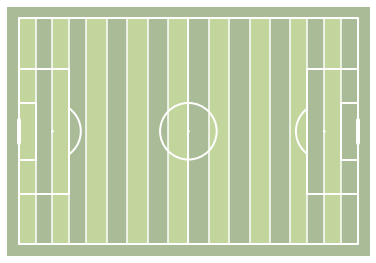

In [15]:
#Get an empty pitch for fun
pitch = Pitch(pitch_color='#aabb97', line_color='white',
              stripe_color='#c2d59d', stripe=True)  # optional stripes
fig, ax = pitch.draw()

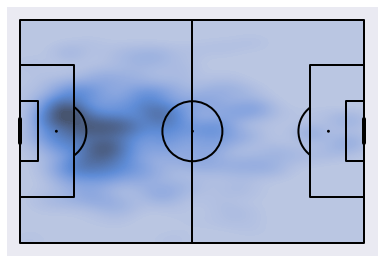

In [16]:
make_player_kde_plot('Lukaku', struct_df)
#make_player_kde_plot('de Bruyne', struct_df)

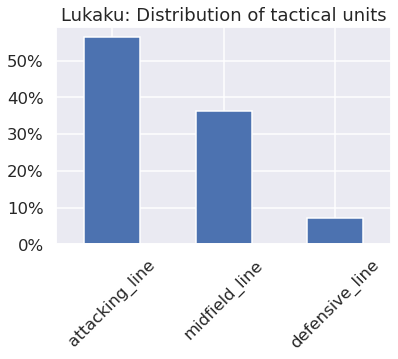

In [17]:
make_player_zones_barplot('Lukaku', result,  names=other_direction_zones)
#make_player_zones_barplot('de Bruyne', result)

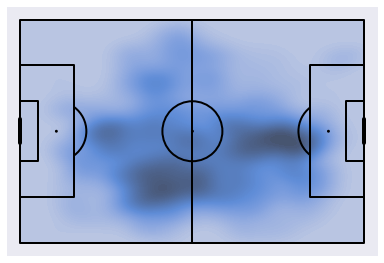

In [18]:
make_player_kde_plot('Barella', struct_df)

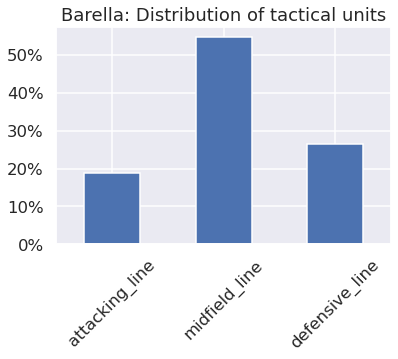

In [19]:
make_player_zones_barplot('Barella', result, names=other_direction_zones)

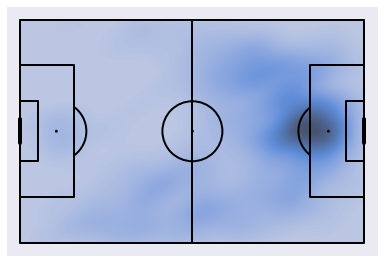

In [20]:
make_player_kde_plot('Skriniar', struct_df)

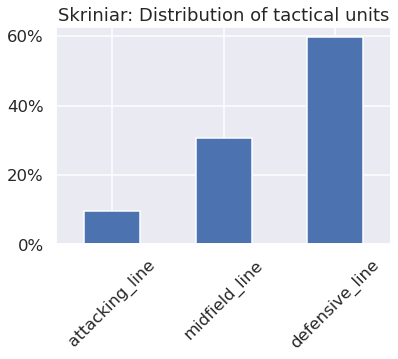

In [21]:
make_player_zones_barplot('Skriniar', result, names=other_direction_zones)